In [1]:
!pip install torch

In [2]:
!pip install torchvision
# 파이토치가 제공하는 다양한 모델을 가져다 쓰기 위해 사용되는 라이브러리

In [3]:
!pip install ipywidgets
# 이미지를 커서를 가지고 이동하면서 이미지를 볼 수 있게하는 라이브러리(슬라이딩 등)

In [4]:
import torch
import os
import cv2
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from torch import nn

# 1. 이미지 파일 경로 불러오기

In [5]:
def list_image_file(data_dir, sub_dir): # './Covid19-dataset/train/', 'Normal'
    image_format = ['jpeg', 'jpg', 'png']
    image_files = []
    
    images_dir = os.path.join(data_dir, sub_dir) # "./Covid19-dataset/train/Normal"
#     print(images_dir)
# 이미지 디렉토리를 만들어서 os.listdir : 경로에 있는 파일을 리스트화하여 file_path에 넣어 줘라
    for file_path in os.listdir(images_dir):
        # 점을 기준으로 (파일이름이랑 확장명 기준으로) [-1] : 끝에거(확장명) 
        # image_format(확장명) -> 이 있다면 
        if file_path.split(".")[-1] in image_format:
            # 파일 이름 경로들을 합처서 넣어라 -> Normal\\001.jpeg
            image_files.append(os.path.join(sub_dir, file_path))
    return image_files

In [6]:
data_dir = './Covid19-dataset/train/'
normals_list = list_image_file(data_dir, 'Normal')
covids_list = list_image_file(data_dir, 'Covid') # Covid : 폴더이름
pneumonias_list = list_image_file(data_dir, 'Viral Pneumonia')

In [7]:
print(len(normals_list))
print(len(covids_list))
print(len(pneumonias_list))

70
111
70


# 2. 이미지 파일을 RGB 3차원 배열로 불러오기

In [8]:
def get_RGB_image(data_dir, file_name):
    # 경로화 시키기 path.join() : 스트링 값으로 사용하지 않는 이유는 특정 함수에서 경로로 인식되지 
    # 않기 때문에 join 방식을 합치는것이 이유이다.
    image_file = os.path.join(data_dir, file_name)
    # 읽어들어와 저장
    image = cv2.imread(image_file)
    # 엠디어레이로 저장되어 있기 때문에 그리고 cv2로 읽어오면 bgr로 읽어와서 바꿔주자
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [9]:
# 3가지 사진의 수 가 다르기 때문에 3개의 길이를 구하고 최솟값을 구해 그 최솟값을 기준으로 만든다.
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list))
# interact 슬라이딩 만들기 위해 0부터 70 -1 까지 범위를 지정한다
@interact(index=(0, min_num_files-1))
def show_samples(index=0): 
    # 현제 데이터 디렉토리에 정상인 사진들을 위 함수에 넣어 알지비로 넣어라
    normal_image = get_RGB_image(data_dir, normals_list[index])
    covid_image = get_RGB_image(data_dir, covids_list[index])
    pneumonia_image = get_RGB_image(data_dir, pneumonias_list[index])
    
    plt.figure(figsize=(12, 8))
    # matplotlib 여러 개의 그래프를 하나의 그림에 나타내도록 
    # 3개의 그래프중 한개를 그리고 첫번째이다.
    plt.subplot(131)
    plt.title("Normal")
    plt.imshow(normal_image)
    plt.subplot(132)
    plt.title("Covid")
    plt.imshow(covid_image)
    plt.subplot(133)
    plt.title("Pneumonia")
    plt.imshow(pneumonia_image)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 3. 학습 데이터셋 클래스 만들기
* 데이터셋 : 데이터(샘플, 검증)을 저장한 것
* 데이터로더: 데이터셋을 접근하기 쉽도록 객체(iterable)로 감싼 것

In [10]:
# 트레인 데이터셋 만들기
train_data_dir = './Covid19-dataset/train/'
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [11]:
class Chest_dataset(Dataset):
    # 생성자
    def __init__(self, data_dir, transform=None): # transform : Train, Testvalid 인지
        self.data_dir = data_dir
        normals = list_image_file(data_dir, 'Normal') # 데이터 뽑아오기
        covids = list_image_file(data_dir, 'Covid')
        pneumonias = list_image_file(data_dir, 'Viral Pneumonia')
        self.files_path = normals + covids + pneumonias # 리스트를 다 더해라 : 갯수가 전부 합쳐지게 된다.
        self.transform = transform
        
    # __len__ : len() 구현하기 위한
    def __len__(self):
        return len(self.files_path) 
    
    # __getitem__ : 인덱스의 순서를 찾아주는 것, 인덱싱하게 되면 호출되는 메소드 
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # os.sep: 디렉토리 분리 문자를 리턴 (/), Normal/01.jpg
        target = class_list.index(self.files_path[index].split(os.sep)[-2])
#         target = class_list.index(self.files_path[index].split(os.sep)[0])
        if self.transform: # 트렌스폼 데이터가 있다면 
            image = self.transform(image)
            target = torch.Tensor([target]).long() # 숫자로 변환 long형으로
        return {'image':image, 'target':target}

In [12]:
dset = Chest_dataset(train_data_dir)

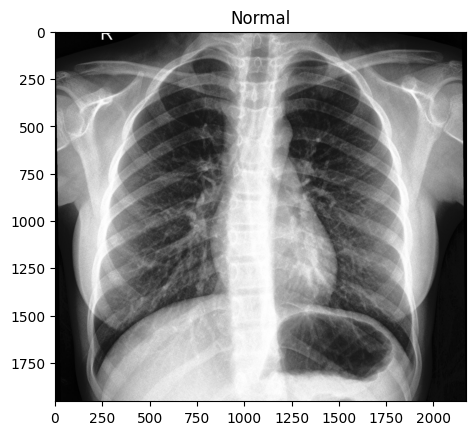

In [13]:
index = 10
plt.title(class_list[dset[index]['target']])
plt.imshow(dset[index]['image']) # 해당 번호의 이미지

# 4. 배열을 연산 가능한 텐서로 변환하기

In [14]:
# transforms.ToTenser(): 텐서로 변환하고 , 픽셀값으 ㅣ범위를 0 ~ 1 로 조정
# Resize(): 사이즈를 설정 224* 224
# Normalize() : 정규화, 
# 각 채널의 평균을 0.5 표준편차를 0.5로 정규화 하여 사용
transformer = transforms.Compose([ # 리스트로 등록을 할것이다.
    transforms.ToTensor(),
    transforms.Resize((224, 224)), # 이미지 사이즈를 정사각형으로 크기를 동일화 시키는것이다.
    transforms.Normalize(mean=[0.5, 0.5, 0.5], # 정규화를 통해 값을 범위안에 들어가게 0과 1사이에 맞게 
                        std=[0.5, 0.5, 0.5])# 왜냐하면 서로 값이 다르는 경우가 있기 떄문에 척도를 동일하게 해준다.
]) 
# 여러가지 작업을 한꺼번에 하게 하는것을 Compose를 이용

In [15]:
train_dset = Chest_dataset(train_data_dir, transformer)
# 클래스안에 데이터 디렉토리와(훈련 데이터) transformer을 넘겨준다

In [29]:
index = 100
image = train_dset[index]['image']
label = train_dset[index]['target']

In [33]:
print(image.shape, label) # tensor[1] : 코로나
# 결과 : 3채널에 모양(크기)는 224*224, 코로나

torch.Size([3, 224, 224]) tensor([1])


# 5. 데이터 로더 구현하기

In [42]:
def build_dataloader(train_data_dir, val_data_dir):
    dataloaders = {}
    train_dset = Chest_dataset(train_data_dir, transformer)
    dataloaders['train'] = DataLoader(train_dset, batch_size=4, shuffle=True, drop_last=True) 
    # 트레인 데이터를 4개 씩 섞고 ,drop_last=True 마지막거를 버려라 
    # {'train' : 데이터...} 담긴 모습
    # 각각의 데이터의 특징(웨이트)을 분류하기 위해 4개로 분류하였고 한번에 전부를 돌리는것보단 조금씩 분석을 하면
    # 얼마만큼 틀렸거나 최적의 경로를 더 빨리 알 수 있기 때문에 적은 수인 4개 정도로 데이터를 분류하는것이 좋다.
    # 251개를 한번에 돌리면 시간이 오래걸리고 반복시에도 시간 문제가 발생한다.
    
    val_dset = Chest_dataset(val_data_dir)
    dataloaders['val'] = DataLoader(val_dset, batch_size=1, shuffle=False, drop_last=False)
    return dataloaders

In [43]:
train_data_dir = './Covid19-dataset/train/'
val_data_dir = './Covid19-dataset/test/'
dataloaders = build_dataloader(train_data_dir, val_data_dir)

In [44]:
for i, d in enumerate(dataloaders['train']): # 반복 인덱스 값과 데이터 값을 출력을 해보자
    print(i, d)
    if i == 0:
        break
        
        # 출력 결과 한번 반복을 돌경우 4개로 나눴기 때문데 4개의 이미지가 있다.
        # target을 최하단부에 보면 섞인 타겟이 4개인것을 알 수 있다.

0 {'image': tensor([[[[-0.1493, -0.1493, -0.1493,  ..., -0.1841, -0.2447, -0.3134],
          [-0.8353, -0.8353, -0.8353,  ..., -0.6908, -0.7464, -0.7784],
          [-0.8289, -0.8289, -0.8289,  ..., -0.8261, -0.8104, -0.8182],
          ...,
          [-0.8275, -0.8275, -0.8275,  ..., -0.6712, -0.7873, -0.8353],
          [-0.8275, -0.8275, -0.8275,  ..., -0.6332, -0.7481, -0.8251],
          [-0.8275, -0.8275, -0.8275,  ..., -0.5958, -0.7389, -0.8196]],

         [[-0.1493, -0.1493, -0.1493,  ..., -0.1841, -0.2447, -0.3134],
          [-0.8353, -0.8353, -0.8353,  ..., -0.6908, -0.7464, -0.7784],
          [-0.8289, -0.8289, -0.8289,  ..., -0.8261, -0.8104, -0.8182],
          ...,
          [-0.8275, -0.8275, -0.8275,  ..., -0.6712, -0.7873, -0.8353],
          [-0.8275, -0.8275, -0.8275,  ..., -0.6332, -0.7481, -0.8251],
          [-0.8275, -0.8275, -0.8275,  ..., -0.5958, -0.7389, -0.8196]],

         [[-0.1493, -0.1493, -0.1493,  ..., -0.1841, -0.2447, -0.3134],
          [-0.8353

In [50]:
d['target'].shape # 4행 1열

torch.Size([4, 1])

# 6. VGG19 (Classification)모델 불러오기
* VGG-19는 19개 계층으로 구성된 컨벌루션 신경망, CNN방식을 사용

In [51]:
# pretrained = True : 미리 학습된 weight들을 가지고 옴
model = models.vgg19(pretrained = True)

In [46]:
d['target'].squeeze() # 

tensor([1, 2, 1, 2])

In [48]:
# PYTHORCH 모델을 SUMMARY 해주는 모듈
!pip install torchsummary

In [52]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size=1, device='cpu') 
# 세이프, 배치사이즈, 디바이스
# param 가중치

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,